Generation 1/75, Best Loss = 0.4695, Accuracy = 0.8057
Generation 1/75, Best Loss = 0.4695, Accuracy = 0.8057
Generation 2/75, Best Loss = 0.4385, Accuracy = 0.8324
Generation 2/75, Best Loss = 0.4385, Accuracy = 0.8324
Generation 3/75, Best Loss = 0.3979, Accuracy = 0.8271
Generation 3/75, Best Loss = 0.3979, Accuracy = 0.8271
Generation 4/75, Best Loss = 0.3751, Accuracy = 0.8235
Generation 4/75, Best Loss = 0.3751, Accuracy = 0.8235
Generation 5/75, Best Loss = 0.3363, Accuracy = 0.8645
Generation 5/75, Best Loss = 0.3363, Accuracy = 0.8645
Generation 6/75, Best Loss = 0.3257, Accuracy = 0.8841
Generation 6/75, Best Loss = 0.3257, Accuracy = 0.8841
Generation 7/75, Best Loss = 0.3080, Accuracy = 0.8913
Generation 7/75, Best Loss = 0.3080, Accuracy = 0.8913
Generation 8/75, Best Loss = 0.3032, Accuracy = 0.8895
Generation 8/75, Best Loss = 0.3032, Accuracy = 0.8895
Generation 9/75, Best Loss = 0.2882, Accuracy = 0.9002
Generation 9/75, Best Loss = 0.2882, Accuracy = 0.9002
Generation

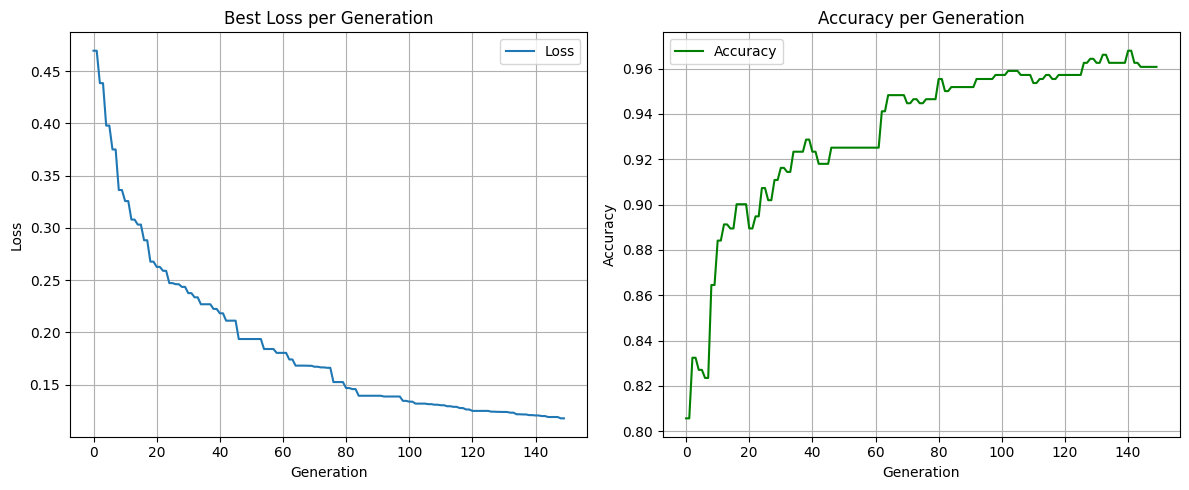

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Load and preprocess dataset
df = pd.read_csv('autism_screening.csv')
df = df.dropna()
columns_to_drop = ['used_app_before', 'country_of_res', 'age_desc', 'relation', 'who_completed_the_test']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

X = MinMaxScaler().fit_transform(df.drop('Class/ASD', axis=1))
y = df['Class/ASD'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model architecture
def create_model():
    return Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(12, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

# Flatten/unflatten weights
def flatten_weights(weights):
    return np.concatenate([w.flatten() for w in weights])

def unflatten_weights(flattened, model):
    shapes = [w.shape for w in model.get_weights()]
    new_weights, idx = [], 0
    for shape in shapes:
        size = np.prod(shape)
        new_weights.append(flattened[idx:idx + size].reshape(shape))
        idx += size
    return new_weights

# Fitness = binary crossentropy loss
def fitness(position):
    model = create_model()
    model.set_weights(unflatten_weights(position, model))
    y_pred = model.predict(X_train, verbose=0).flatten()
    loss = tf.keras.losses.binary_crossentropy(y_train, y_pred).numpy().mean()
    return loss

# Genetic Algorithm parameters
pop_size = 50
n_generations = 75
mutation_rate = 0.1
crossover_rate = 0.8

model = create_model()
dim = len(flatten_weights(model.get_weights()))
lb, ub = -1 * np.ones(dim), 1 * np.ones(dim)
population = np.random.uniform(lb, ub, (pop_size, dim))

# Tracking
loss_history = []
acc_history = []

# GA main loop
import gc
from tensorflow.keras import backend as K

# Clear memory before starting
K.clear_session()
tf.compat.v1.reset_default_graph()

loss_history = []
acc_history = []

model = create_model()  # Create once
dim = len(flatten_weights(model.get_weights()))
lb, ub = -1 * np.ones(dim), 1 * np.ones(dim)
population = np.random.uniform(lb, ub, (pop_size, dim))

# Modified GA loop
for generation in range(n_generations):
    fitness_values = []
    valid_population = []

    for ind in population:
        try:
            model.set_weights(unflatten_weights(ind, model))
            y_pred = model.predict(X_train, verbose=0).flatten()

            # Handle NaNs
            if np.any(np.isnan(y_pred)):
                continue

            loss = tf.keras.losses.binary_crossentropy(y_train, y_pred).numpy().mean()
            fitness_values.append(loss)
            valid_population.append(ind)
        except:
            continue

    # Continue only if we have valid candidates
    if len(valid_population) < 2:
        print("Too few valid individuals. Reinitializing population...")
        population = np.random.uniform(lb, ub, (pop_size, dim))
        continue

    fitness_values = np.array(fitness_values)
    population = np.array(valid_population)
    sorted_indices = np.argsort(fitness_values)
    population = population[sorted_indices]
    fitness_values = fitness_values[sorted_indices]

    best_weights = population[0]
    model.set_weights(unflatten_weights(best_weights, model))
    y_pred_classes = (model.predict(X_train, verbose=0).flatten() > 0.5).astype(int)
    acc = accuracy_score(y_train, y_pred_classes)

    loss_history.append(fitness_values[0])
    acc_history.append(acc)

    print(f"Generation {generation+1}/{n_generations}, Best Loss = {fitness_values[0]:.4f}, Accuracy = {acc:.4f}")

    # Elitism
    next_gen = [population[0], population[1]]

    while len(next_gen) < pop_size:
        if np.random.rand() < crossover_rate:
            parents = population[np.random.choice(len(population)//2, 2, replace=False)]
            cp = np.random.randint(1, dim - 1)
            child1 = np.concatenate((parents[0][:cp], parents[1][cp:]))
            child2 = np.concatenate((parents[1][:cp], parents[0][cp:]))
        else:
            child1, child2 = population[np.random.choice(len(population), 2, replace=False)]

        for child in [child1, child2]:
            if np.random.rand() < mutation_rate:
                child += np.random.normal(0, 0.1, size=dim)
                child = np.clip(child, lb, ub)
            next_gen.append(child)

    population = np.array(next_gen[:pop_size])

    # 🧹 Memory cleanup
    K.clear_session()
    gc.collect()


    # Track and print
    loss_history.append(fitness_values[0])
    acc_history.append(acc)
    print(f"Generation {generation+1}/{n_generations}, Best Loss = {fitness_values[0]:.4f}, Accuracy = {acc:.4f}")

    # Elitism
    next_gen = [population[0], population[1]]

    while len(next_gen) < pop_size:
        if np.random.rand() < crossover_rate:
            parents = population[np.random.choice(pop_size//2, 2, replace=False)]
            cp = np.random.randint(1, dim - 1)
            child1 = np.concatenate((parents[0][:cp], parents[1][cp:]))
            child2 = np.concatenate((parents[1][:cp], parents[0][cp:]))
        else:
            child1, child2 = population[np.random.choice(pop_size, 2, replace=False)]

        for child in [child1, child2]:
            if np.random.rand() < mutation_rate:
                mutation_vector = np.random.normal(0, 0.1, size=dim)
                child += mutation_vector
                child = np.clip(child, lb, ub)
            next_gen.append(child)

    population = np.array(next_gen[:pop_size])

# Final evaluation
model.set_weights(unflatten_weights(population[0], model))
y_pred_probs = model.predict(X_test).flatten()
y_pred_classes = (y_pred_probs > 0.5).astype(int)

final_loss = fitness(population[0])
acc = accuracy_score(y_test, y_pred_classes)
cm = confusion_matrix(y_test, y_pred_classes)

print(f"\n✅ Final Test Accuracy: {acc:.4f}")
print(f"✅ Final Test Loss: {final_loss:.4f}")
print("✅ Confusion Matrix:\n", cm)

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title("Best Loss per Generation")
plt.xlabel("Generation")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Accuracy', color='green')
plt.title("Accuracy per Generation")
plt.xlabel("Generation")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
